In [1]:
%load_ext autoreload
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

from helpers import helpplots_numu as plothelp
from helpers import helpfunction as helper
from helpers import plot_dicts_numu as plot_dicts

pd.set_option("display.max_columns", 500)

<IPython.core.display.Javascript object>

In [3]:
%autoreload

<IPython.core.display.Javascript object>

In [4]:
run = 1
input_dir = "./input/23Nov/"
output_dir = "./output/run{}/".format(run)

<IPython.core.display.Javascript object>

In [5]:
%%time
data = pickle.load(open(input_dir+"run{}_slimmed.pckl".format(run), 'rb'))
samples = list(data.keys())
title_str = "MicroBooNE Run{}: {:.1e} POT".format(run, data["on"]["pot"])

CPU times: user 424 ms, sys: 909 ms, total: 1.33 s
Wall time: 2.27 s


<IPython.core.display.Javascript object>

In [6]:
q_muon_select = "trk_llr_pid_score_v>0.2 & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4"
q_event_select = "reco_fid_vol & muon_candidate & ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20 & CosmicIP>20 & slpdg==14 & topological_score>0.1 & all_start_contained & all_end_contained"
q_preselect_tracks = "reco_fid_vol & trk_score_v>0.8 & trk_len_v>20 & pfp_generation_v==2 & trk_distance_v<4 & ~(crtveto & crthitpe>100) & _closestNuCosmicDist>20 & CosmicIP>20 & slpdg==14 & all_start_contained"

<IPython.core.display.Javascript object>

In [12]:
fields = list(data["nu"]["daughters"].keys())
[f for f in fields if "pdg" in f]

['slpdg', 'nu_pdg', 'backtracked_pdg']

<IPython.core.display.Javascript object>

In [8]:
for k, v in data.items():
    if "_closestNuCosmicDist" not in v["daughters"]:
        v["daughters"]["_closestNuCosmicDist"] = 999

    # Add fiducial reco sce vtx
    v["daughters"]["reco_fid_vol"] = np.repeat(
        helper.is_fid(
            *v["daughters"][
                ["reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z"]
            ]
            .xs(0, level="daughter")
            .values.T
        ),
        v["daughters"]["n_pfps"].xs(0, level="daughter"),
    )

    muon_candidate = v["daughters"].eval(q_muon_select)
    muon_cand_maxll = (
        v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
        .groupby("event")
        .transform(max)
        == v["daughters"][muon_candidate]["trk_llr_pid_score_v"]
    )
    v["daughters"]["muon_candidate"] = False
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "muon_candidate"
    ] = True

    end_mask = helper.is_contain(
        v["daughters"]["trk_sce_end_x_v"],
        v["daughters"]["trk_sce_end_y_v"],
        v["daughters"]["trk_sce_end_z_v"],
    )
    start_mask = helper.is_contain(
        v["daughters"]["trk_sce_start_x_v"],
        v["daughters"]["trk_sce_start_y_v"],
        v["daughters"]["trk_sce_start_z_v"],
    )
    v["daughters"]["all_start_contained"] = start_mask
    v["daughters"]["all_start_contained"] = (
        v["daughters"]["all_start_contained"].groupby("event").transform(min)
    )
    v["daughters"]["all_end_contained"] = end_mask
    v["daughters"]["all_end_contained"] = (
        v["daughters"]["all_end_contained"].groupby("event").transform(min)
    )
    # This code defines a containment of all other objects except of the muon.
    v["daughters"]["non_muon_end_contained"] = end_mask
    v["daughters"].loc[
        muon_cand_maxll[muon_cand_maxll == True].index, "non_muon_end_contained"
    ] = True
    v["daughters"]["non_muon_end_contained"] = (
        v["daughters"]["non_muon_end_contained"].groupby("event").transform(min)
    )
    # At some point you would like to broadcast this
    v["daughters"]["numuccinc"] = v["daughters"].eval(q_event_select)
    v["daughters"]["track_at_vtx"] = v["daughters"].eval(
        "trk_distance_v<3 & trk_distance_v>=0 & trk_score_v>0.3"
    )
    v["daughters"]["track_at_vtx"] = (
        v["daughters"]["track_at_vtx"].groupby("event").transform(sum)
    )

<IPython.core.display.Javascript object>

In [9]:
nu_df = pd.DataFrame(data["nu"]["mc"])

<IPython.core.display.Javascript object>

In [10]:
nu_df["true_vtx_fid"] = helper.is_fid(
    data["nu"]["mc"]["true_nu_vtx_x"],
    data["nu"]["mc"]["true_nu_vtx_y"],
    data["nu"]["mc"]["true_nu_vtx_z"],
)

<IPython.core.display.Javascript object>

In [11]:
q_30 = "abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0 & true_vtx_fid"
q_31 = "abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0 & true_vtx_fid"
q_32 = "abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0 & true_vtx_fid"
q_33 = "abs(nu_pdg)==14 & nmuon==0 & true_vtx_fid"
q_10 = "abs(nu_pdg)==12 & true_vtx_fid"
q_5 = "true_vtx_fid==0"
new_cat = (
    nu_df.eval(q_30) * 30
    + nu_df.eval(q_31) * 31
    + nu_df.eval(q_32) * 32
    + nu_df.eval(q_33) * 33
    + nu_df.eval(q_10) * 10
    + nu_df.eval(q_5) * 5
)
nu_df["category"] = new_cat

<IPython.core.display.Javascript object>

In [12]:
q_30 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & nproton==0 & (npi0+npion)==0"
q_31 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & nproton>0 & (npi0+npion)==0"
q_32 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & (npi0+npion)>0"
q_33 = "category!=5 & abs(nu_pdg)==14 & nmuon==0"
q_10 = "category!=5 & abs(nu_pdg)==12"
q_5 = "category==5"

for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["category"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "category"] = 4

<IPython.core.display.Javascript object>

In [13]:
q_30 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & interaction==0"
q_31 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & interaction==1"
q_32 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & interaction==2"
q_310 = "category!=5 & abs(nu_pdg)==14 & nmuon==1 & interaction==10"
q_33 = "category!=5 & abs(nu_pdg)==14 & nmuon==0"
q_10 = "category!=5 & abs(nu_pdg)==12"
q_5 = "category==5"

for k, v in data.items():
    if k not in helper.data_samples:
        new_cat = (
            v["daughters"].eval(q_30) * 30
            + v["daughters"].eval(q_31) * 31
            + v["daughters"].eval(q_32) * 32
            + v["daughters"].eval(q_310) * 310
            + v["daughters"].eval(q_33) * 33
            + v["daughters"].eval(q_10) * 10
            + v["daughters"].eval(q_5) * 5
        )
        v["daughters"]["cat_int"] = new_cat
        cosmic = (v["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            v["daughters"]["category"] != 5
        )
        v["daughters"].loc[cosmic, "cat_int"] = 4

<IPython.core.display.Javascript object>

In [14]:
print(data["nu"]["daughters"].query("numuccinc")["category"].value_counts())
print(nu_df["category"].value_counts())
print(sum(data["on"]["daughters"].eval("numuccinc")))

31    12490
32     6416
30     3101
33     1913
5      1507
4       945
10       43
Name: category, dtype: int64
5     346449
31     85482
33     58562
32     44003
30     18420
10      1326
0          3
Name: category, dtype: int64
2144


<IPython.core.display.Javascript object>

In [15]:
sum(data["nu"]["daughters"].eval("numuccinc & category>29 & category<33")) / sum(
    nu_df.eval("category>29 & category<33")
)

0.14879145397383456

<IPython.core.display.Javascript object>

19342.72610580921
3340.975696980953
87036.96388548613
13033.540869235992
43976.460385620594
6414.314481973648


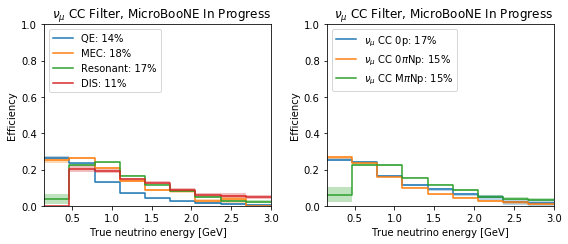

<IPython.core.display.Javascript object>

In [16]:
# eff per mode
cats = [0, 1, 2, 10]
field = "nu_e"
x_min = 0.15
x_max = 3
n_bins = 10
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))


cats = [0, 10, 1, 2]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("interaction==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("interaction==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("interaction==@cat")[
        "weightSpline"
    ]

    eff, unc_low, unc_up, edges = plothelp.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[0].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[0].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plot_dicts.int_labels_true[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[0].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[0].set_xlabel("True neutrino energy [GeV]")
ax[0].set_ylabel("Efficiency")
ax[0].set_ylim(0, 1)
ax[0].set_xlim(x_min, x_max)
ax[0].legend(loc="upper left")


cats = [30, 31, 32]
for cat in cats:
    num = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")[field]
    )
    den = nu_df.query("category>29 & category<33").query("category==@cat")[field]

    num_w = (
        data["nu"]["daughters"]
        .query("numuccinc & category>29 & category<33")
        .query("category==@cat")["weightSpline"]
    )
    den_w = nu_df.query("category>29 & category<33").query("category==@cat")[
        "weightSpline"
    ]
    print(sum(den_w))
    print(sum(num_w))
    eff, unc_low, unc_up, edges = plothelp.efficiency_post(
        num, den, num_w=num_w, den_w=den_w, n_bins=n_bins, x_min=x_min, x_max=x_max
    )
    ax[1].fill_between(edges, eff - unc_low, eff + unc_up, alpha=0.3, step="post")
    ax[1].step(
        edges,
        eff,
        where="post",
        label="{0}: {1:.0f}%".format(
            plot_dicts.category_labels[cat], sum(num_w) / sum(den_w) * 100
        ),
    )
ax[1].set_title(r"$\nu_\mu$ CC Filter, MicroBooNE In Progress", loc="right")
ax[1].set_xlabel("True neutrino energy [GeV]")
ax[1].set_ylabel("Efficiency")
ax[1].set_ylim(0, 1)
ax[1].set_xlim(x_min, x_max)
ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig(output_dir + "numu_efficiency_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 572. 	#entries 9608
MC category: Resonant: 437. 	#entries 7936
MC category: DIS: 67. 	#entries 1219
MC category: MEC: 174. 	#entries 3169
MC category: $\nu_\mu$ NC: 105. 	#entries 1913
MC category: $\nu_e$: 2. 	#entries 43
MC category: Cosmic: 53. 	#entries 945
MC category: Out of FV: 84. 	#entries 1507
MC category: No slice: 4. 	#entries 75


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 46.


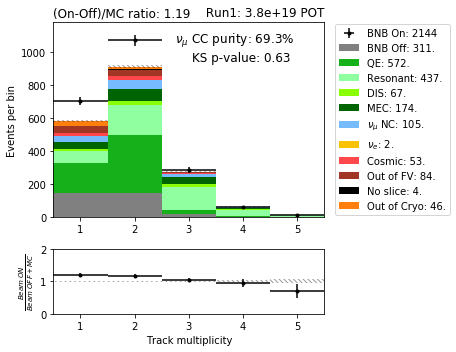

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "track_at_vtx",
    "Track multiplicity",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_int",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.9,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_vtxntrack_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 572. 	#entries 9608
MC category: Resonant: 437. 	#entries 7936
MC category: DIS: 67. 	#entries 1219
MC category: MEC: 174. 	#entries 3169
MC category: $\nu_\mu$ NC: 105. 	#entries 1913
MC category: $\nu_e$: 2. 	#entries 43
MC category: Cosmic: 53. 	#entries 945
MC category: Out of FV: 84. 	#entries 1507
MC category: No slice: 4. 	#entries 75


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 46.


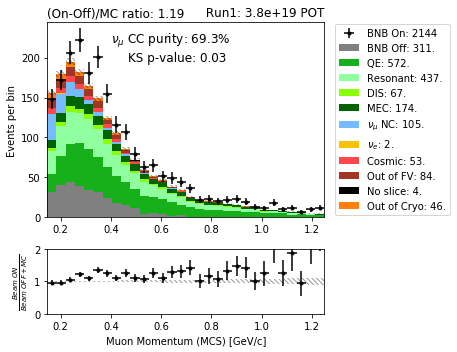

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(4 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_mcs_muon_mom_v",
    "Muon Momentum (MCS) [GeV/c]",
    N_bins=30,
    x_min=0.146,
    x_max=1.25,
    query="numuccinc",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_int",
    y_max_scaler=1.1,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_mcsmom_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 572. 	#entries 9608
MC category: Resonant: 437. 	#entries 7936
MC category: DIS: 67. 	#entries 1219
MC category: MEC: 174. 	#entries 3169
MC category: $\nu_\mu$ NC: 105. 	#entries 1913
MC category: $\nu_e$: 2. 	#entries 43
MC category: Cosmic: 53. 	#entries 945
MC category: Out of FV: 84. 	#entries 1507
MC category: No slice: 4. 	#entries 75


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 45.


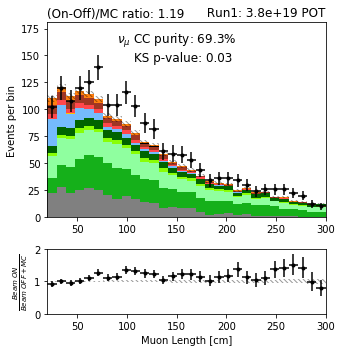

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_len_v",
    "Muon Length [cm]",
    N_bins=30,
    x_min=20,
    x_max=300,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_int",
    y_max_scaler=1.3,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.7,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_trklen_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: QE: 572. 	#entries 9608
MC category: Resonant: 437. 	#entries 7936
MC category: DIS: 67. 	#entries 1219
MC category: MEC: 174. 	#entries 3169
MC category: $\nu_\mu$ NC: 105. 	#entries 1913
MC category: $\nu_e$: 2. 	#entries 43
MC category: Cosmic: 53. 	#entries 945
MC category: Out of FV: 84. 	#entries 1507
MC category: No slice: 4. 	#entries 75


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 46.


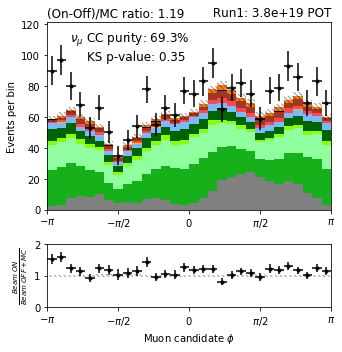

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_phi_v",
    r"Muon candidate $\phi$",
    N_bins=30,
    x_min=-np.pi,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_int",
    y_max_scaler=1.25,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.0,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_phi_run{}.pdf".format(run), bbox_inches="tight")

MC category: QE: 572. 	#entries 9608
MC category: Resonant: 437. 	#entries 7936
MC category: DIS: 67. 	#entries 1219
MC category: MEC: 174. 	#entries 3169
MC category: $\nu_\mu$ NC: 105. 	#entries 1913
MC category: $\nu_e$: 2. 	#entries 43
MC category: Cosmic: 53. 	#entries 945
MC category: Out of FV: 84. 	#entries 1507
MC category: No slice: 4. 	#entries 75


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 46.


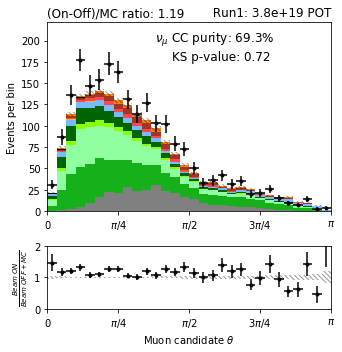

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(
    ncols=1,
    nrows=2,
    figsize=(3 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax,
    "trk_theta_v",
    r"Muon candidate $\theta$",
    N_bins=30,
    x_min=0,
    x_max=np.pi,
    query="numuccinc",
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="event_int",
    y_max_scaler=1.25,
)
ax[0].text(
    ax[0].get_xlim()[1] * 0.8,
    ax[0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(
    output_dir + "data_mc/numu_theta_run{}.pdf".format(run), bbox_inches="tight"
)

MC category: $\nu_\mu$ CC 0p: 594. 	#entries 10399
MC category: $\nu_\mu$ CC 0$\pi$Np: 3599. 	#entries 64703
MC category: $\nu_\mu$ CC M$\pi$Np: 1663. 	#entries 30228
MC category: $\nu_\mu$ NC: 441. 	#entries 8017
MC category: $\nu_e$: 9. 	#entries 167
MC category: Cosmic: 366. 	#entries 6566
MC category: Out of FV: 874. 	#entries 15699


/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf1we = cwei1[[np.searchsorted(data1, data, side='right')]]
/home/wouter/Documents/Jupyter/searchingfornues/helpers/helpplots_numu.py:351: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cdf2we = cwei2[[np.searchsorted(data2, data, side='right')]]


DRT: 4.7e+02
MC category: $p$: 1707. 	#entries 31003
MC category: $\mu$: 4499. 	#entries 80556
MC category: $e$: 3. 	#entries 50
MC category: $\pi^{\pm}$: 547. 	#entries 9948
MC category: $n$: 3. 	#entries 48
MC category: $\gamma$: 39. 	#entries 702
MC category: $K$: 4. 	#entries 64
MC category: Cosmic: 745. 	#entries 13408
DRT: 4.7e+02


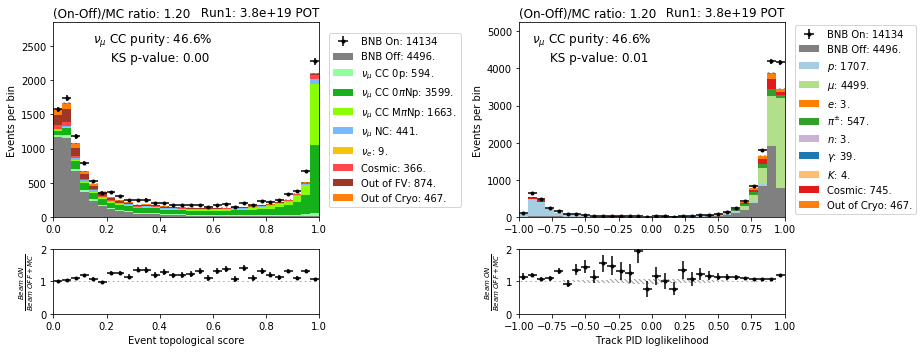

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plothelp.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_category",
    y_max_scaler=1.25,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p = plothelp.plot_panel_data_mc(
    data,
    ax.T[1],
    "trk_llr_pid_score_v",
    r"Track PID loglikelihood",
    N_bins=30,
    x_min=-1,
    x_max=1,
    query=q_preselect_tracks,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="event_pdg",
    y_max_scaler=1.25,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.0,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_\mu$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


fig.tight_layout()
fig.savefig(output_dir + "data_mc/numu_pret_run{}.pdf".format(run), bbox_inches="tight")

# Done